# Prediction of Sepsis from Clinical Data
*Xiaoyu Wang(xnw3)*, *Lexin Lu(ll425)*, *Zhihui Zhao(zz274)*, *Yili Luo(yl824)*, *ShiTing Lu(sl676)*



## Introduction

Sepsis is a significant public health concern. According to WHO and CDC's data, nearly 1.7 million people in the U.S. develop sepsis and 270,000 people die from sepsis each year. In addition, U.S. hospitals spend more than 24 billion dollars on sepesis each year (13% U.S. healthcare expenses). Detection and treatement are critical for improving sepsis outcome. Taking advantage of the public data from https://physionet.org/content/challenge-2019/1.0.0/, which is sourced from ICU patients in three separate hospital systems, we tried to develop an automated, mechine-learning algorithm for the detection of sepsis to improve the Sepsis diagnosis.

In [3]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import sklearn
from sklearn import linear_model, preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import SGDClassifier, Lasso
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix, classification_report, auc, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.inspection import permutation_importance

import umap
from umap import UMAP
import os
import pickle
import random
import imblearn
# pip install -U imbalanced-learn
from imblearn.over_sampling import SMOTENC
# pip install --upgrade tensorflow
import tensorflow as tf
# %pip install xgboost
import xgboost as xgb

## Data

The original data are in packed in `psc` files and can be download directly from the website mentioned above. Training dataset A includes 20,336 subjects’ psv files, while test dataset B has 20,000 subjects’ psc files. For simplicity, we directly load the cleaned datasets in the reports. The detailed reading-in process can be found in `AllCode` file. 

1. Outcome variable: `SepsisLabel`  
    The outcome variable is the `SepsisLabel`. For sepsis patients, it equals to $1$ if $t>= t_sepsis - 6$ and $0$ if $t<t_sepsis-6$, while for non-sepsis patients, `SepsisLabel` is $0$. 
    
2. Covariates:  
    Both datasets totally have 40 covariates. This includes:
    * 8 vital physical signs: Heart rate (beats/min), Pulse oximetry (%), Temperature (degree), etc;
    * 26 laboratory values: Measure of excess bicarbonate (mmol/L), Calcium(mg/dL), Hematocrit (%), etc
    * 6 demographical features: Age, Gender, Administrative identifier for ICU unit, etc.

## Data Cleaning

After combined `psv` files into two large datasets, we conducted further data cleaning work. 

First, We removed hospital-level variables `Unit1`, `Unit2`, `HospAdmTime`, and `ICULOS` since the information in these columns is not related to individual-level prediction. Another column of `ETCO2` was also dropped in both dataset A and dataset B because it only contains `NA` value.  

Then, we spent time in the imputation of missing values. We assumed that each patient has unique characteristic and every value has ongoing time specified. Thus, primarily, the `NAs` were imputed based on the last or next recordsthe missing values, meaning that if there is a value in previous or next time period, then impute with the previous or the next one. Otherwise, we replaced the mean for continuous variables and mode for categorical variables if the values are missing. 

Finally, considering the great benefit of early detection of Sepsis, we extracted the initial situation of patients, i.e. using the laboratory results and demographical features of the first time when patients visited hospitals. This gave us 20,336 records in training set and 20,000 data in test set. Notice that the final datasets are imbalanced: percentages of $0$ (do not develop sepsis) in the `SepsisLabel` in datasets A and B are around 91% and 94%, respectively. They will be balanced before modeling process using the SMOTE method later. 

In [5]:
df_preA = pd.read_csv("dataset/training_setA/training_clean1.psv",sep = ",")
df_preA.head()
df_preB = pd.read_csv("dataset/training_setB/testing_clean1.psv",sep = ",")
df_preB.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,...,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,SepsisLabel,SubjectID
0,93.0,92.5,36.5,110.0,76.0,56.0,22.0,NaN,NaN,NaN,...,35.3,11.3,NaN,10.8,NaN,170.0,73.0,1.0,0.0,p100001
1,56.5,100.0,35.2,129.0,75.0,52.5,23.0,35.0,NaN,NaN,...,31.4,11.1,NaN,13.2,NaN,85.0,83.0,1.0,0.0,p100002
2,130.0,96.0,36.6,129.0,87.0,72.0,24.0,NaN,NaN,NaN,...,32.3,10.8,NaN,15.5,NaN,337.0,48.0,1.0,0.0,p100003
3,65.0,100.0,36.7,140.0,84.0,65.0,14.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,67.0,1.0,0.0,p100004
4,55.0,100.0,36.1,131.0,68.0,50.5,24.0,NaN,NaN,NaN,...,24.7,8.0,32.3,10.6,NaN,421.0,50.0,1.0,0.0,p100005


In [ ]:
## drop EtCO2 since all is missing
df_preA = df_preA.drop(columns = ['EtCO2'])

## Impute rest of Missing Value with mean (continuous) and mode (categorical)
df_preA_noID = df_preA.drop(columns = ['SubjectID'])
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
miss_mean_imputer = miss_mean_imputer.fit(df_preA_noID)
imputed_df_preA = miss_mean_imputer.transform(df_preA_noID)
imputed_df_preA = pd.DataFrame(data = imputed_df_preA, columns = df_preA_noID.columns)
df_finalA = pd.concat([df_preA['SubjectID'], imputed_df_preA], axis = 1)

In [7]:
## the percentage of label as 0 in training A
len(df_finalA[df_finalA['SepsisLabel'] == 0])/len(df_finalA)

0.911978756884343

In [8]:
## drop EtCO2 since all is missing
df_preB = df_preB.drop(columns = ['EtCO2'])
## Impute Missing Value with mean (continuous) and mode (categorical)
df_preB_noID = df_preB.drop(columns = ['SubjectID'])
miss_mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
miss_mean_imputer = miss_mean_imputer.fit(df_preB_noID)
imputed_df_preB = miss_mean_imputer.transform(df_preB_noID)
imputed_df_preB = pd.DataFrame(data = imputed_df_preB, columns = df_preB_noID.columns)

df_finalB = pd.concat([df_preB['SubjectID'], imputed_df_preB], axis = 1)

In [9]:
## the percentage of label as 0
len(df_finalB[df_finalB['SepsisLabel'] == 0])/len(df_finalB)

0.9429

## EDA 
We did the following visualizations to help us get a general understanding of the data:
1. Distribution Plots of each covariate 
2. Correlation acorss covariates
3. PCA for training data
4. UMAP for training data

### Distribution plots
We first plotted the distribution of all features. From the plots below, we can see that Excluding the categorical variables `Gender` and `SepsisLabel`, most histograms indicate that the variables are not normally distributed. Some variables that are relatively approximately normal are: Temp, Chlorid, Hct, and Hgb. Therefore, we used normalization to rescale the data. 

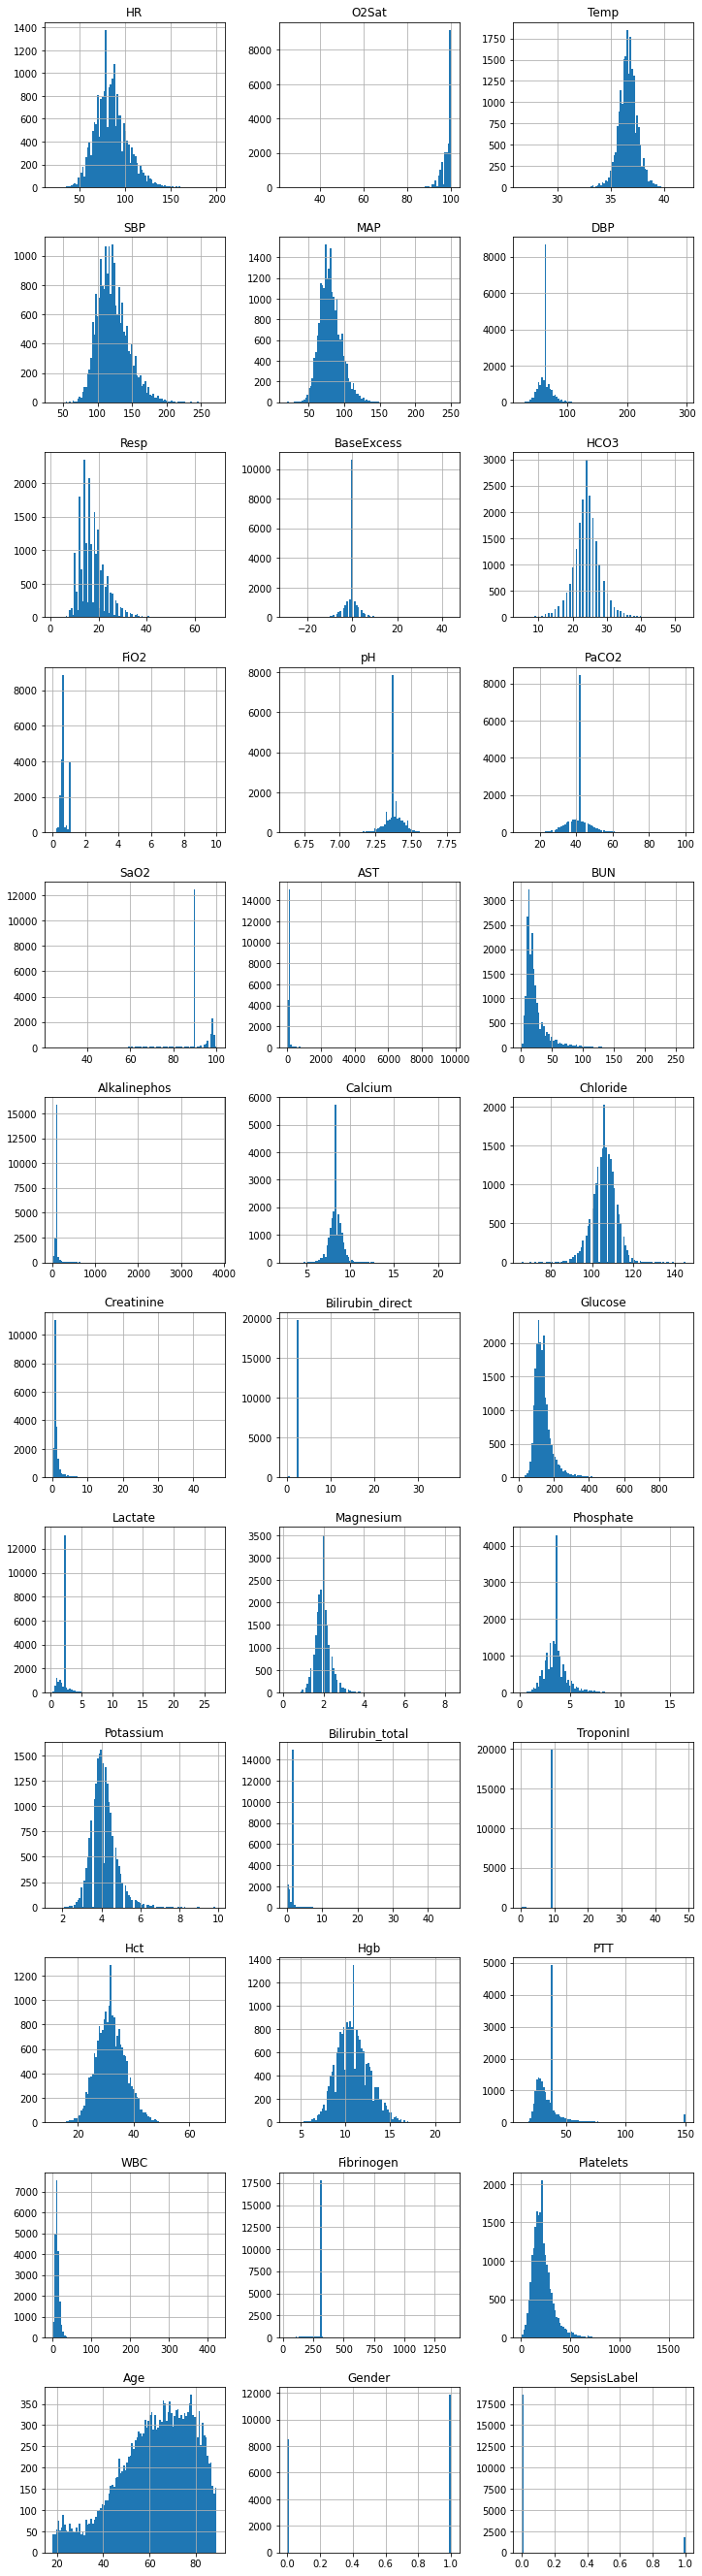

In [10]:
# plot all histrogram for all varaibles
fig, axes = plt.subplots(len(df_finalA.columns) // 3 , 3, figsize = (12,48))

i = 1
for triaxis in axes:
    for axis in triaxis:
        df_finalA.hist(column = df_finalA.columns[i], bins = 100, ax=axis)
        i = i+1

### Correlation in covariates
We can observe that most of the variables do not have high correlation with each other. Some exceptions are MAP&SBP, BaseExcess&HCO3, Hgb&HcT, which all have correlation above 0.5. Therefore, we are not too concerned about problems caused by high correlation such as multicollinearity.

[Text(0.5, 0, 'HR'),
 Text(1.5, 0, 'O2Sat'),
 Text(2.5, 0, 'Temp'),
 Text(3.5, 0, 'SBP'),
 Text(4.5, 0, 'MAP'),
 Text(5.5, 0, 'DBP'),
 Text(6.5, 0, 'Resp'),
 Text(7.5, 0, 'BaseExcess'),
 Text(8.5, 0, 'HCO3'),
 Text(9.5, 0, 'FiO2'),
 Text(10.5, 0, 'pH'),
 Text(11.5, 0, 'PaCO2'),
 Text(12.5, 0, 'SaO2'),
 Text(13.5, 0, 'AST'),
 Text(14.5, 0, 'BUN'),
 Text(15.5, 0, 'Alkalinephos'),
 Text(16.5, 0, 'Calcium'),
 Text(17.5, 0, 'Chloride'),
 Text(18.5, 0, 'Creatinine'),
 Text(19.5, 0, 'Bilirubin_direct'),
 Text(20.5, 0, 'Glucose'),
 Text(21.5, 0, 'Lactate'),
 Text(22.5, 0, 'Magnesium'),
 Text(23.5, 0, 'Phosphate'),
 Text(24.5, 0, 'Potassium'),
 Text(25.5, 0, 'Bilirubin_total'),
 Text(26.5, 0, 'TroponinI'),
 Text(27.5, 0, 'Hct'),
 Text(28.5, 0, 'Hgb'),
 Text(29.5, 0, 'PTT'),
 Text(30.5, 0, 'WBC'),
 Text(31.5, 0, 'Fibrinogen'),
 Text(32.5, 0, 'Platelets'),
 Text(33.5, 0, 'Age'),
 Text(34.5, 0, 'Gender'),
 Text(35.5, 0, 'SepsisLabel')]

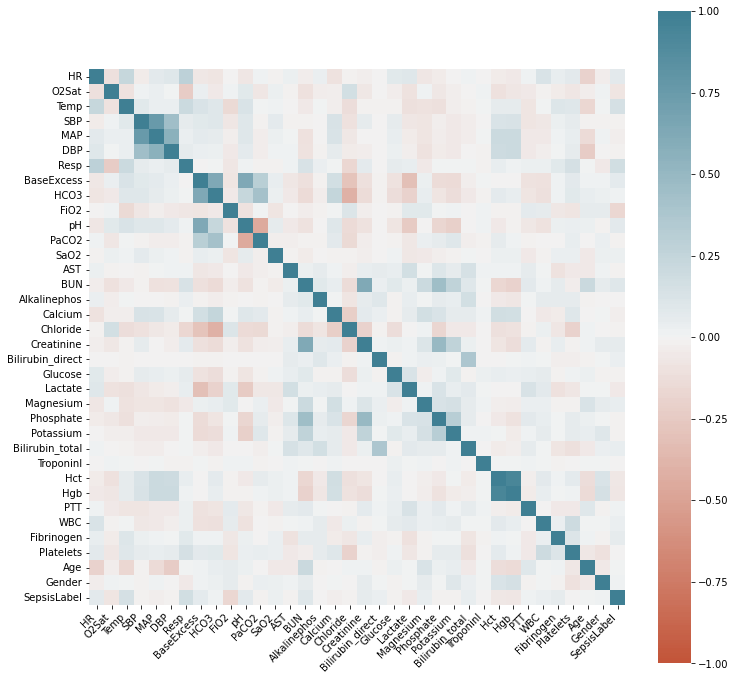

In [11]:
fig = plt.figure(figsize=(12,12))
corr = df_finalA.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [12]:
# Scaling
scaler = StandardScaler()
df_finalA[df_finalA.columns[1:35]] = scaler.fit_transform(df_finalA[df_finalA.columns[1:35]])
df_finalB[df_finalA.columns[1:35]] = scaler.transform(df_finalB[df_finalB.columns[1:35]])

### PCA for training data
Applying the PCA method, we will reduce the dimension of the features down to 2 and observe whether there are any evidence of clustering for sepsis and non-spesis patients. From the plot, we can observe that there are no clear separation between the patients. 

In [13]:
features = ['HR','O2Sat','Temp','SBP','MAP','DBP','Resp','BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2',
 'AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate','Magnesium',
 'Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets','Age',
        'Gender']
# Separating out the features
x_A = df_finalA.loc[:, features].values
# Separating out the target
y_A = df_finalA.loc[:,['SepsisLabel']].values
# Standardizing the features
x_A = StandardScaler().fit_transform(x_A)

In [14]:
pca = PCA(n_components=2)
principalComponents_A = pca.fit_transform(x_A)
principalDf_A = pd.DataFrame(data = principalComponents_A
             , columns = ['principal component 1', 'principal component 2'])
finalDf_A = pd.concat([principalDf_A, df_finalA[['SepsisLabel']]], axis = 1)

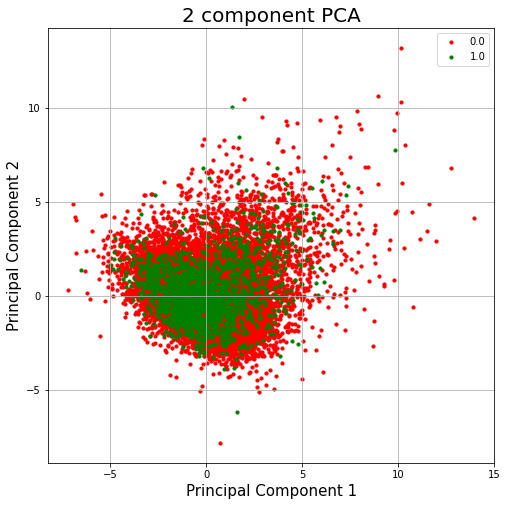

In [15]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0.0,1.0]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_A['SepsisLabel'] == target
    ax.scatter(finalDf_A.loc[indicesToKeep, 'principal component 1']
               , finalDf_A.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 10)
ax.legend(targets)
ax.grid()

### umap for training data
By applying the UMAP method, we are able to reduce the deminson of the data and create a 2D visualization of how the original parameters is related to the Sepsis label. We trained the umap reducer using the cleaned and normalized data A, and obtained a 2-dimensional representation of all the selected features. We then plot the 2 new feature column by `SepsisLable` in a scatter plot, where we can observe that there are no clear separation between sepsis patient and non-sepsis patient.

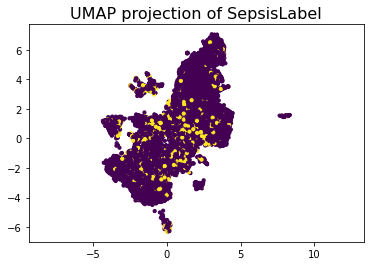

In [16]:
reducer = umap.UMAP()
embedding_A = reducer.fit_transform(x_A)

plt.scatter(
    embedding_A[:, 0],
    embedding_A[:, 1],
    c=df_finalA.SepsisLabel,
    s=10
)
plt.title('UMAP projection of SepsisLabel', fontsize=16)
plt.gca().set_aspect('equal', 'datalim')

# Model Implementation

## Data Pre-processing

For convenience, we treated normalized dataset A as training set and normalized dataset B as test set. The outcome and covariates were separated and denoted as `x` and `y`, respectively.

In [29]:
## separate the train_x, train_y, test_x, test_y
x_train = df_finalA.iloc[:,1:36]
y_train = df_finalA.loc[:, ['SepsisLabel']]
x_test = df_finalB.iloc[:,1:36]
y_test = df_finalB.loc[:, ['SepsisLabel']]

### Balancing Data

In [30]:
print("Original y:")
print(y_train.groupby(y_train["SepsisLabel"]).value_counts(normalize=False)) 
#18546 "0" + 1790 "1"

Original y:
SepsisLabel
0.0    18546
1.0     1790
dtype: int64


The original data is highly imbalanced: only 1,790 participants were test positive of Sepsis, which the remaining 18,546 participants were labeled 0 for non-positive. This largely influences the models in classifing the minority class-diagnosed Sepsis, which is more important.  Therefore, we used Synthetic Minority Oversampling Technique (SMOTE) to balance data before building models. Particularly in our case, since one of the covariate `Gender` is binary, we applied the `SMOTENC` function from `imblearn.over_sampling` module and set the `categorical_features` argument to specify it. After balancing on our training sets, we obtained 18,546 zero-labeled records and 18,546 ones of Sepsis. 

In [31]:
sm = SMOTENC(random_state=42, categorical_features=[34]) # Column 35 is Gender, a categorical variable
# generate balanced training datasets using SMOTE
x_res, y_res = sm.fit_resample(x_train, y_train)
# convert the outcome into a numpy array for later convenience
y_res = np.ravel(y_res)

In [32]:
print("After SMOTE:")
print("0:", len(y_res[y_res==0]))
print("1:", len(y_res[y_res==1]))
#18546 "0" + 18546 "1"

After SMOTE:
0: 18546
1: 18546


### Variable Selection

Fitting a LASSO regression, variable selection was conducted before applying classification models. Coefficients of three covariates are relatively small (<0.005): `Chloride(mmol/L)`, `Troponin I (ng/mL)` and `Hematocrit (%)`. Therefore, the above features were dropped, and the final datasets for modeling were obtained.

In [21]:
lasso_res = GridSearchCV(
    Lasso(), 
    param_grid = {"alpha": np.arange(5e-05, 2e-04, 1e-06)},
    scoring='neg_mean_squared_error',
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0),
    n_jobs= -1
).fit(
    x_res, y_res
)
# summarize
print('MSE: %.3f' % lasso_res.best_score_)
print('Config: %s' % lasso_res.best_params_)

MSE: -0.177
Config: {'alpha': 0.00013199999999999977}


In [33]:
lasso_coef = lasso_res.best_estimator_.coef_
lasso_coef

array([ 0.01318951, -0.03946967,  0.08545039, -0.00664377, -0.02730352,
        0.01094795,  0.10074287,  0.00873825, -0.01293656, -0.12578299,
        0.02512151,  0.01405773,  0.01807017,  0.00699177,  0.02372579,
       -0.01804076, -0.00531194,  0.00334292,  0.01667495,  0.00538894,
       -0.00950088, -0.0269503 ,  0.04007773, -0.01588716, -0.0201449 ,
        0.01215504, -0.00112452,  0.00038257, -0.05636893,  0.01626599,
        0.03224709,  0.01086034, -0.02830717,  0.01585452,  0.17045032])

In [34]:
discard_coef = x_res.columns[abs(lasso_coef)<=0.005] # if the absolute value of coefficients are less than 0.005, we viewed 
discard_coef

Index(['Chloride', 'TroponinI', 'Hct'], dtype='object')

In [35]:
# Final data using in following models
x_test =x_test.drop(discard_coef, axis=1)
x_res =x_res.drop(discard_coef, axis=1)
x_train = x_train.drop(discard_coef, axis=1)

### Helper Function

In [36]:
# confusion matrix re-formatting
def cm_format(y_test, y_pred):
    """
    This function is used to transform confusion matrix into a more readable format
    """
    confmat = confusion_matrix(y_test, y_pred)
    df = pd.DataFrame({'Prediction 1': [confmat[1,1], confmat[0,1]], 'Prediction 0': [confmat[1,0], confmat[0,0]]})
    df.index = ['Test 1', 'Test 0']
    return(df)

## Model 1: Logistic Regression
Logistic regression was used on the balanced dataset. The stochastic gradient descent (SGD) was used to the regularized linear methods to help build an estimator for classification and regression problems. The SGD classifier works well with large-scale datasets and is an efficient easy-to-implement method. Compared with the accuracy, the model with `l2` norm and 0.011 `alpha` has best performance and was selected.

In [ ]:
np.random.seed(1234)
parameters = {'loss':['log'], 'penalty': ('l1', 'l2', 'elasticnet', 'none'), 'alpha': list(np.arange(0.001,1,0.01))}
logistic = SGDClassifier()
logistic_cv = GridSearchCV(logistic, parameters, 
                           cv = sklearn.model_selection.StratifiedKFold(5, shuffle=True, random_state=1234))
logistic_cv.fit(x_res,y_res)

In [46]:
LR_best = SGDClassifier(loss = logistic_cv.best_params_["loss"], 
                        penalty = logistic_cv.best_params_["penalty"], 
                        alpha = logistic_cv.best_params_["alpha"])
LR_best.fit(x_res,y_res)

SGDClassifier(alpha=0.011, loss='log')

In [49]:
y_pred_LR = LR_best.predict(x_test)
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91     18858
         1.0       0.18      0.49      0.26      1142

    accuracy                           0.84     20000
   macro avg       0.57      0.67      0.59     20000
weighted avg       0.92      0.84      0.87     20000



## Model 2: KNN
The second model we use is the K-nearest neighbor on the balanced dataset. The best number of `k` selected via cross validation is 16 with an accuracy score of 0.84. 

In [50]:
KNN_gs = GridSearchCV(
   KNeighborsClassifier(),
   param_grid = {
     "n_neighbors": np.arange(15, 25)
   },
   cv = sklearn.model_selection.StratifiedKFold(10, shuffle=True, random_state=1234),
   scoring = "accuracy",
   n_jobs = 4
 ).fit(
   x_res, y_res
 )

In [54]:
y_pred_KNN = KNN_gs.predict(x_test)
print(classification_report(y_test, y_pred_KNN))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     18858
         1.0       0.13      0.55      0.21      1142

    accuracy                           0.76     20000
   macro avg       0.55      0.66      0.53     20000
weighted avg       0.92      0.76      0.82     20000



## Model 3: Naive Bayes
Naive bayes  was used on the balanced dataset as well. The tuning parameter is `var_smoothing`, which is the portion of the largest variance of all features that is added to variances for calculation stability. The best value selected via cross validation is 1.53448 with an accuracy score of 0.746.

In [55]:
NB_gs = GridSearchCV(
  GaussianNB(),
  param_grid = {
      "var_smoothing": np.linspace(1.5, 2.0, 30)
  },
  cv = sklearn.model_selection.StratifiedKFold(10, shuffle=True, random_state=1234),
  scoring = "accuracy",
  n_jobs = -1
).fit(
  x_res, y_res
)

In [57]:
y_pred_NB = NB_gs.predict(x_test)
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

         0.0       0.97      0.84      0.90     18858
         1.0       0.18      0.57      0.27      1142

    accuracy                           0.83     20000
   macro avg       0.57      0.71      0.59     20000
weighted avg       0.93      0.83      0.86     20000



## Model 4: Random Forest
The fourth model we applied is Random forest. Based on the balanced dataset, we tuned parameters using 5-fold cross-validation method. The optimal model with the maximum depth of the tree being 50, results in an 96.29% training accuracy. However, when we applied it to test data, the random forest performs poorly in predicting Sepsis patients, which leads to the result that the test accuracy is only about 0.77.

In [59]:
rf_res = GridSearchCV(
    RandomForestClassifier(), 
    param_grid = {
        "max_depth": [10,15, 20, 50, 150], 
        "n_estimators": [10, 50, 100], 
        "min_samples_leaf": [1, 2, 5]},
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=0),
    n_jobs= -1
).fit(
    x_res, y_res
)

In [60]:
y_pred_rf = rf_res.best_estimator_.predict(x_test)
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     18858
         1.0       0.10      0.48      0.17      1142

    accuracy                           0.73     20000
   macro avg       0.53      0.61      0.50     20000
weighted avg       0.91      0.73      0.80     20000



## Model 5: XGBoost

Finally, the extreme gradient boosting was used on the balanced dataset. Because `XGBClassifier` has a built-in parameter `scale_pos_weight`, which controls the balance of positive and negative weights for an imbalance dataset, using the balanced dataset from SMOTE is not necessary. The `scale_pos_weight` was set to be the number of negative results divided by the number of positive results as default. Other parameters were tuned via `GridSearchCV` function, and the optimized parameters are: `eta` = 0.8, `max_depth` = 3, `n_estimators` = 150. 

In [ ]:
y_tr = np.ravel(y_train)

xbg_gs = GridSearchCV(
   xgb.XGBClassifier(),
   param_grid = {'n_estimators': range(50,200,50), 'max_depth': range(2,4,1), 
                 'eta': list(np.arange(0.2,1,0.2)), 'scale_pos_weight': [sum(y_tr==0)/sum(y_tr==1)]},
   cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234),
   scoring = "accuracy",
   n_jobs = 4
 ).fit(
   x_train, y_train
 )

print("Best Estimator from XGBoost is:", xbg_gs.best_params_)
print("accuracy :", xbg_gs.best_score_)

Best Estimator from XGBoost is: {'eta': 0.8, 'max_depth': 3, 'n_estimators': 150, 'scale_pos_weight': 10.360893854748603}
accuracy : 0.8657550072664385


In [67]:
y_pred_xgb = xbg_gs.best_estimator_.predict(x_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.96      0.80      0.87     18858
         1.0       0.13      0.52      0.21      1142

    accuracy                           0.78     20000
   macro avg       0.55      0.66      0.54     20000
weighted avg       0.92      0.78      0.84     20000



### Neural Network for Classification with Tensorflow
A neural network for classification was also used on the balanced dataset, but it did not achieve a large improvement. The model consists of 3 layers with activation function of sigmoid. The accuracy score isn’t very different from those of the models above, and the model did not improve as the number of epochs increased, meaning the model was not able to converge. Therefore, we did not present the models and results here in the report, but more details can be found in `AllCode` file.

# Discussion & Conclusions

## Performance comparison

To compare the optimal method, we emphasize on minimizing false positive predictions for the aim of predicting whether a patient develops sepsis. False positive predictions have serious public health consequences because the delay of antibiotic treatment increases the mortality of sepsis patients. Thus, the model performance is evaluated mainly based on the accuracy of prediction, area under curve (AUC) score, and the false positive count. 

From the accuracy table, the logistic regression (LR) has the highest accuracy of 84.12%, followed by the naive bayes (NB) with an accuracy of 82.53%. The extreme gradient boosting (XGB) has an accuracy of 78.09%, the random forest (RF) model has an accuracy of 72.82%, and the k-nearest neighbors (KNN) has an accuracy of 75.91%. 

We then plotted all receiver operating characteristic (ROC) curves in a single graph (method learned from https://stackoverflow.com/questions/42894871/how-to-plot-multiple-roc-curves-in-one-plot-with-legend-and-auc-scores-in-python). As can be seen, the LR and NB have better performance than other models. The KNN and XGB have similar performances and the RF has the worst performance. The AUC score for LR is slightly higher than the AUC score for NB: 0.848 versus 0.825. 

The confusion matrices are shown below for each method as well. As can be seen in the confusion tables, the NB outperformed LR with fewer false negative predictions: 486 versus 584. The NB model is selected as the best model because it minimizes the false negative rates at a small cost of accuracy.


In [ ]:
# test accuracy and AUC summary
df = pd.DataFrame({'LR': [0.8412,0.7801], 'KNN': [0.7591,0.7165], 'NB': [0.8253,0.7595],
                   'RF': [0.7282,0.6306], 'XGB': [0.7809,0.7452]})
df.index = ['Accuracy','AUC']
df

,LR,KNN,NB,RF,XGB
Accuracy,0.8412,0.7591,0.8253,0.7282,0.7809
AUC,0.7801,0.7165,0.7595,0.6306,0.7452


In [68]:
# Confusion Matrix
print("Logistics Regression")
print(cm_format(y_test, y_pred_LR))
print("KNN")
print(cm_format(y_test, y_pred_KNN))
print("Naive Bayes")
print(cm_format(y_test, y_pred_NB))
print("Random Forest")
print(cm_format(y_test, y_pred_rf))
print("XGBoost")
print(cm_format(y_test, y_pred_xgb))

Logistics Regression
        Prediction 1  Prediction 0
Test 1           556           586
Test 0          2591         16267
KNN
        Prediction 1  Prediction 0
Test 1           633           509
Test 0          4309         14549
Naive Bayes
        Prediction 1  Prediction 0
Test 1           656           486
Test 0          3009         15849
Random Forest
        Prediction 1  Prediction 0
Test 1           547           595
Test 0          4842         14016
XGBoost
        Prediction 1  Prediction 0
Test 1           589           553
Test 0          3829         15029


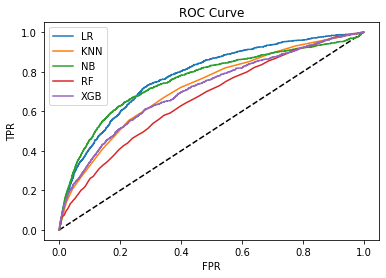

In [71]:
# AUC plot
y_pred_prob1 = LR_best.predict_proba(x_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(y_test, y_pred_prob1)

y_pred_prob2 = KNN_gs.predict_proba(x_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, y_pred_prob2)

y_pred_prob3 = NB_gs.predict_proba(x_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test, y_pred_prob3)

y_pred_prob4 = rf_res.predict_proba(x_test)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test, y_pred_prob4)

y_pred_prob5 = xbg_gs.predict_proba(x_test)[:,1]
fpr5 , tpr5, thresholds5 = roc_curve(y_test, y_pred_prob5)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "LR")
plt.plot(fpr2, tpr2, label= "KNN")
plt.plot(fpr3, tpr3, label= "NB")
plt.plot(fpr4, tpr4, label= "RF")
plt.plot(fpr5, tpr5, label= "XGB")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('ROC Curve')
plt.show()


## Variable Importance

Because there is no built-in method to evaluate feature importance in `GaussianNB`, we will use the `permutation_importance` function from `sklearn.inspection` to analyze the importance of features. From the plot, we can observe that `HCO3`, `Alkalinephos` are the 2 most important features in the NB model. These 2 variables are also significant in the LR model as well. Some other features that also have decent predictive power are: `Creatinine`, `TroponinI`, and `Hct`.

<StemContainer object of 3 artists>

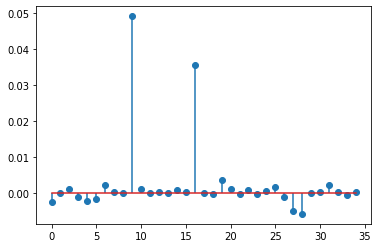

In [59]:
# NB
from sklearn.inspection import permutation_importance
imps = permutation_importance(NB_gs, x_test, y_test)
pyplot.stem(imps.importances_mean, use_line_collection=True)

<StemContainer object of 3 artists>

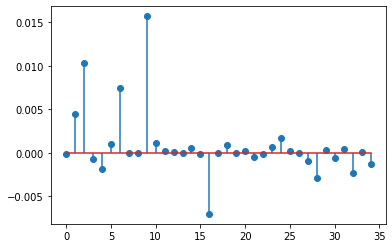

In [58]:
# Logistic regression
coef = LR_best.coef_.ravel()
imps_lr = permutation_importance(LR_best, x_test, y_test)
pyplot.stem(imps_lr.importances_mean, use_line_collection=True)